In [ ]:
#!pip install tensorflow

In [47]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tabulate import tabulate

## Data Exploration and Pre-processing

### Filtered Train and Test set

In [2]:
neg_train,neg_test,pos_train,pos_test= [],[],[],[]
neg_train2,neg_test2,pos_train2,pos_test2= [],[],[],[]

foldpath1 = '../Data/neg'
foldpath2 = '../Data/pos'

for filename in tqdm(os.listdir(foldpath1)):
    try:
        with open(f"../Data/neg/{filename}", 'r', encoding='utf-8') as file:
            #print(file.readlines()[:3])
            temresult = []
            for l in file.readlines():
                #eachline = l.strip().split(' ')
                eachline = re.split(r'[ \',.?:!;()"{}%*@~\-/_`=..]+', l.strip())
                temresult.extend(eachline)
            filtered_file = [i for i in temresult if not i.isdigit() and i != ''] #no empty string and numbers
            #print(filtered_file)
    except Exception as e:
        print(f"An error occurred while reading {filename}: {e}")

    if int(filename[2:5])<700:
        neg_train.append(filtered_file)
        neg_train2.extend(filtered_file)
    else:
        neg_test.append(filtered_file)
        neg_test2.extend(filtered_file)

for filename in tqdm(os.listdir(foldpath2)):
    try:
        with open(f"../Data/pos/{filename}", 'r', encoding='utf-8') as file:
            #print(file.readlines()[:3])
            temresult = []
            for l in file.readlines():
                #eachline = l.strip().split(' ')
                eachline = re.split(r'[ \',.?:!;()"{}%*@~\-/_`=...]+', l.strip())
                temresult.extend(eachline)
            filtered_file = [i for i in temresult if not i.isdigit() and i != ''] #no empty string and numbers
            #print(filtered_file)
    except Exception as e:
        print(f"An error occurred while reading {filename}: {e}")

    if int(filename[2:5])<700:
        pos_train.append(filtered_file)
        pos_train2.extend(filtered_file)
    else:
        pos_test.append(filtered_file)
        pos_test2.extend(filtered_file)

100%|██████████| 1000/1000 [00:00<00:00, 3236.37it/s]


In [3]:
#Data prep
#create value pair 

pos_train_pair = [(text_value, 1) for text_value in pos_train]
neg_train_pair = [(text_value, -1) for text_value in neg_train]
pos_test_pair = [(text_value, 1) for text_value in pos_test]
neg_test_pair = [(text_value, -1) for text_value in neg_test]

Train =  pos_train_pair + neg_train_pair
Test = pos_test_pair + neg_test_pair

x_train_text = [eachtuple[0] for eachtuple in Train] 
y_train = [eachtuple[1] for eachtuple in Train] 
x_test_text = [eachtuple[0] for eachtuple in Test] 
y_test = [eachtuple[1] for eachtuple in Test] 

### Data exploration

In [4]:
All_data = pos_train + pos_test + neg_train + neg_test
All_words = pos_train2 + pos_test2 + neg_train2 + neg_test2

print(f'There are {len(set(All_words))} unique words of the whole texts data')
print(set(All_words))

There are 39316 unique words of the whole texts data
{'spall', 'sugiyana', 'barbie', 'sleazy', 'insist', 'veers', 'countdown', 'sundry', 'madrid', 'angelina', 'craze', 'goofball', 'imparts', 'hourglass', 'nickname', 'honking', 'stall', 'kamil', 'bumble', 'disorders', 'adjuster', 'sakari', 'dentist', 'walsh', 'natural', 'zus', 'nightclubs', 'cartoonishly', 'backpacker', 'rmd', 'shoeless', 'misgivings', 'studying', 'translating', 'conspirators', 't2', 'rica', 'clothesline', 'sapping', 'thyme', 'country', 'watchdog', 'feverishly', 'abortion', 'moon', 'renna', 'vest', 'moviemakers', 'chainsmoking', 'promesse', 'enrages', 'pindar', 'directoral', 'salkinds', 'babboons', 'jinn', 'ascetic', 'sheltering', 'shallows', 'ultimate', 'costume', 'narrator', 'nigra', 'slugfest', 'nanny', 'longtime', 'storylines', 'prevention', 'necklace', 'bigelow', 'lola', 'kaminski', 'facepaint', 'moping', 'blueprints', 'entities', 'squads', 'mare', 'bulleye', 'african', 'huevelman', 'pissing', 'kissed', 'champs', '

In [5]:
All_data_length = map(lambda x: len(x), All_data)
all_len = list(All_data_length)
avg_len = np.mean(all_len)
std_len = np.std(all_len)

print(f'Average review length is {avg_len:.0f} words and the standard deviation is {std_len:.0f} words.')

Average review length is 666 words and the standard deviation is 294 words.


Text(0, 0.5, 'Frequency')

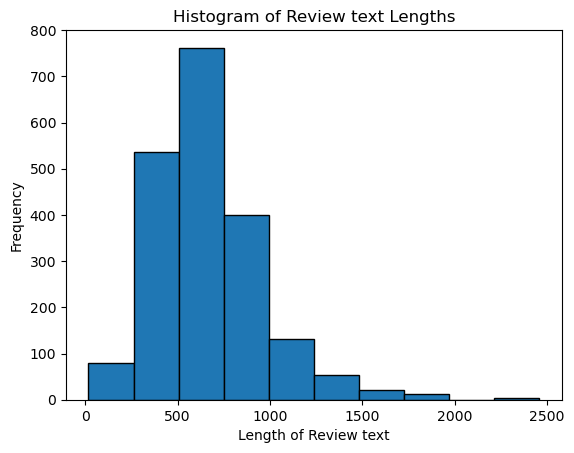

In [6]:
plt.hist(all_len, edgecolor='black') 
plt.title('Histogram of Review text Lengths')
plt.xlabel('Length of Review text')
plt.ylabel('Frequency')

### Tokenization 

In [7]:
### Tokenization process
tokenizer = Tokenizer(num_words=5001)
tokenizer.fit_on_texts(x_train_text) 

x_train_tok = tokenizer.texts_to_sequences(x_train_text)
x_test_tok= tokenizer.texts_to_sequences(x_test_text)

### Truncate

In [8]:
sorted_len = sorted(all_len)
index_70percent = int(0.7 * len(all_len))
index_90percent = int(0.9 * len(all_len))
L = sorted_len[index_70percent]
L2 = sorted_len[index_90percent]

print(f'The length {L} that 70% of the reviews have a length below it')
print(f'The length {L2} that 90% of the reviews have a length below it')

The length 760 that 70% of the reviews have a length below it
The length 1028 that 90% of the reviews have a length below it


In [9]:
x_train = tf.keras.utils.pad_sequences(x_train_tok, padding="post", maxlen=L)
x_test = tf.keras.utils.pad_sequences(x_test_tok, padding="post", maxlen=L)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Word Embedding

In [11]:
#input_dim = vocab_size +1 ,+1 accommodate zero padding
# size: L×32 matrix for each text

embedding_layer = layers.Embedding(input_dim=5000+1,output_dim=32,input_length=L)

#Build Sequential model
model = Sequential()

#add layer into the model and flatten
model.add(embedding_layer)
model.add(layers.Flatten())

## Multi-layer Perceptron

In [12]:
#continue for model creation : add three hidden layers and one output layer
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) #output layer 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model set up
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 760, 32)           160032    
                                                                 
 flatten (Flatten)           (None, 24320)             0         
                                                                 
 dense (Dense)               (None, 50)                1216050   
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2

In [13]:
model.fit(x_train, y_train,epochs=2,batch_size=10)
#Accuracy Report
trainacc = model.evaluate(x_train,y_train)[1]
testacc = model.evaluate(x_test,y_test)[1]

print(f'Train accuracy of MLP model: {trainacc:.2}')
print(f'Test accuracy of MLP model: {testacc:.2}')

Epoch 1/2


2024-05-06 18:51:49.151415: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


140/140 [==============================] - 1s 4ms/step - loss: 0.7017 - accuracy: 0.4879
Epoch 2/2
19/19 [==============================] - 0s 2ms/step - loss: 0.6607 - accuracy: 0.6167
Train accuracy of MLP model: 0.82
Test accuracy of MLP model: 0.62


##  Convolutional Neural Network

In [14]:
cnnmodel = Sequential()
cnnmodel.add(embedding_layer)
cnnmodel.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cnnmodel.add(layers.MaxPooling1D(pool_size=2, strides=2))
cnnmodel.add(layers.Flatten())
cnnmodel.add(layers.Dense(50, activation="relu"))
cnnmodel.add(layers.Dropout(0.2))
cnnmodel.add(layers.Dense(50, activation="relu"))
cnnmodel.add(layers.Dropout(0.5))
cnnmodel.add(layers.Dense(50, activation="relu"))
cnnmodel.add(layers.Dropout(0.5))
cnnmodel.add(layers.Dense(1, activation='sigmoid')) #output layer 

cnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnnmodel.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 760, 32)           160032    
                                                                 
 conv1d (Conv1D)             (None, 758, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 379, 32)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 12128)             0         
                                                                 
 dense_4 (Dense)             (None, 50)                606450    
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

In [15]:
cnnmodel.fit(x_train, y_train,epochs=2,batch_size=10)
trainacc_cnn= cnnmodel.evaluate(x_train,y_train)[1]
testacc_cnn = cnnmodel.evaluate(x_test,y_test)[1]

print(f'Train accuracy of 1D CNN model: {trainacc_cnn:.2}')
print(f'Test accuracy of 1D CNN  model: {testacc_cnn:.2}')

Epoch 1/2
140/140 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.5300
Epoch 2/2
19/19 [==============================] - 0s 2ms/step - loss: 0.5474 - accuracy: 0.7667
Train accuracy of 1D CNN model: 0.88
Test accuracy of 1D CNN  model: 0.77


## Long Short-Term Memory Recurrent Neural Network

In [16]:
LSTMmodel = Sequential()
LSTMmodel.add(embedding_layer)
LSTMmodel.add(layers.LSTM(32))
LSTMmodel.add(layers.Dropout(0.2))
LSTMmodel.add(layers.Dense(256, activation='relu'))
LSTMmodel.add(layers.Dropout(0.2))
LSTMmodel.add(layers.Dense(1, activation='sigmoid')) #output layer 

LSTMmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTMmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 760, 32)           160032    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 256)               8448      
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 177,057
Trainable params: 177,057
Non-tr

2024-05-06 18:52:04.753686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-06 18:52:04.754130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-06 18:52:04.754807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [17]:
#select best epochs
train_acc_dic = {}
test_acc_dic = {}

for e in range(10,51):
    LSTMmodel.fit(x_train, y_train,epochs=e,batch_size=10)

    trainacc_lstm= LSTMmodel.evaluate(x_train,y_train)[1]
    testacc_lstm = LSTMmodel.evaluate(x_test,y_test)[1]
    train_acc_dic[e]=trainacc_lstm
    test_acc_dic[e] = testacc_lstm


Epoch 1/10


2024-05-06 18:52:06.794487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-06 18:52:06.795109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-06 18:52:06.795705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

140/140 [==============================] - 12s 79ms/step - loss: 0.6922 - accuracy: 0.5200
Epoch 2/10
140/140 [==============================] - 11s 79ms/step - loss: 0.6591 - accuracy: 0.5800
Epoch 3/10
140/140 [==============================] - 11s 79ms/step - loss: 0.6184 - accuracy: 0.6150
Epoch 4/10
140/140 [==============================] - 11s 79ms/step - loss: 0.6037 - accuracy: 0.6264
Epoch 5/10
140/140 [==============================] - 11s 79ms/step - loss: 0.5763 - accuracy: 0.6321
Epoch 6/10
140/140 [==============================] - 11s 80ms/step - loss: 0.5711 - accuracy: 0.6021
Epoch 7/10
140/140 [==============================] - 11s 80ms/step - loss: 0.5623 - accuracy: 0.6157
Epoch 8/10
140/140 [==============================] - 11s 79ms/step - loss: 0.5490 - accuracy: 0.6171
Epoch 9/10
140/140 [==============================] - 11s 80ms/step - loss: 0.5476 - accuracy: 0.6107
Epoch 10/10
 1/44 [..............................] - ETA: 9s - loss: 0.5759 - accuracy: 0.250

2024-05-06 18:53:59.027810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-06 18:53:59.028312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-06 18:53:59.029083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 0s 23ms/step - loss: 1.0164 - accuracy: 0.5583
Epoch 1/11
140/140 [==============================] - 11s 80ms/step - loss: 0.5474 - accuracy: 0.6293
Epoch 2/11
140/140 [==============================] - 11s 79ms/step - loss: 0.5449 - accuracy: 0.6279
Epoch 3/11
140/140 [==============================] - 11s 79ms/step - loss: 0.5473 - accuracy: 0.6193
Epoch 4/11
140/140 [==============================] - 11s 79ms/step - loss: 0.5493 - accuracy: 0.6207
Epoch 5/11
140/140 [==============================] - 11s 79ms/step - loss: 0.5444 - accuracy: 0.6329
Epoch 6/11
140/140 [==============================] - 11s 79ms/step - loss: 0.5397 - accuracy: 0.6293
Epoch 7/11
140/140 [==============================] - 11s 79ms/step - loss: 0.5413 - accuracy: 0.6186
Epoch 8/11
140/140 [==============================] - 11s 80ms/step - loss: 0.6545 - accuracy: 0.6207
Epoch 9/11
140/140 [==============================] - 11s 80ms/step - loss: 0.5472 - accuracy: 0

Train accuracy of LSTM model (Epochs = 22): 0.996
Test accuracy of LSTM model (Epochs = 22): 0.753


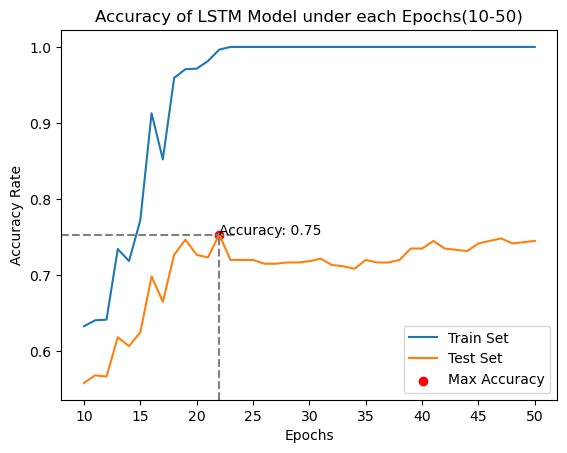

In [46]:
Optimal_e = max(test_acc_dic, key=test_acc_dic.get)
trainacc_lstm = train_acc_dic[Optimal_e]
testacc_lstm = test_acc_dic[Optimal_e]

print(f'Train accuracy of LSTM model (Epochs = {Optimal_e}): {trainacc_lstm:.3}')
print(f'Test accuracy of LSTM model (Epochs = {Optimal_e}): {testacc_lstm:.3}')


plt.plot(range(10,51),train_acc_dic.values(), label='Train Set')
plt.plot(range(10,51),test_acc_dic.values(), label='Test Set')
plt.annotate(f'Accuracy: {testacc_lstm:.2f}', xy=(Optimal_e, testacc_lstm))
plt.scatter(Optimal_e, testacc_lstm, color='red', label=f'Max Accuracy')
plt.axvline(Optimal_e, color='gray', linestyle='--', ymax=0.45) 
plt.axhline(testacc_lstm, color='gray', linestyle='--', xmax=0.35)     

plt.xlabel('Epochs')
plt.ylabel('Accuracy Rate')
plt.title('Accuracy of LSTM Model under each Epochs(10-50)')

plt.legend()
plt.show()


## Model Result Summary 

In [49]:
acc = [['MLP model', trainacc, testacc],
    ['1D CNN model', trainacc_cnn, testacc_cnn],
    ['LSTM model (Epochs = 22)', trainacc_lstm, testacc_lstm]]

col_name = ['Model', 'Train Accuracy', 'Test Accuracy']
print(tabulate(acc, headers=col_name, tablefmt='grid'))

+--------------------------+------------------+-----------------+
| Model                    |   Train Accuracy |   Test Accuracy |
+==========================+==================+=================+
| MLP model                |         0.822857 |        0.616667 |
+--------------------------+------------------+-----------------+
| 1D CNN model             |         0.882857 |        0.766667 |
+--------------------------+------------------+-----------------+
| LSTM model (Epochs = 22) |         0.996429 |        0.753333 |
+--------------------------+------------------+-----------------+


## Resource

https://www.geeksforgeeks.org/python-os-listdir-method/
https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
https://stackoverflow.com/questions/57693333/processing-before-or-after-train-test-split
https://www.tensorflow.org/text/guide/word_embeddings
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
https://keras.io/guides/sequential_model/
https://keras.io/api/layers/regularization_layers/dropout/
https://keras.io/api/models/model_training_apis/
https://keras.io/api/layers/convolution_layers/convolution1d/
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html